## CSCS530 Winter 2017
#### Complex Systems 530 - Computer Modeling of Complex Systems (Winter 2017)

  * Course ID: CMPLXSYS 530
  * Course Title: Computer Modeling of Complex Systems
  * Term: Winter 2017



## PD (Game Theory) Model

In this notebook, we implement a very simple "Prisoner's Dilemma" model using two different types of players and demonstrate how to run a parameter sweep for the model.

For more information on the Prisoner's Dilemma and its application to real world topics, see https://en.wikipedia.org/wiki/Prisoner's_dilemma

#### [View this repository on NBViewer](http://nbviewer.jupyter.org/github/lynetteshaw/cscs-530-wi2017/tree/master/)

In [1]:
%matplotlib inline

import numpy.random
import matplotlib.pyplot as plt

### Payoff Structure

In a Prisoner's Dilemma, players choose whether to remain silent ("Cooperate") or confess ("Defect"). The best collective outcome is for both prisoners to Cooperate, while the best individual outcome is to Defect while the other player Cooperates. 

This structure for the game can be represented using a payoff map.

In [2]:
# Setup payoffs
payoff_map = {("C", "C"): (-1, -1),
             ("C", "D"): (-10, 0),
             ("D", "C"): (0, -10),
             ("D", "D"): (-4, -4)}

In [3]:
my_payoff, your_payoff = payoff_map[("D", "C")]
print("I got {0}".format(my_payoff))
print("You got {0}".format(your_payoff))

I got 0
You got -10


### Player Types

In the case of an "Iterated PD," players play one another for a repeated set of PD games with the goal of maximizing their long-term payoff. A host of potential strategies can be used to decide what to play in a given round. Here we consider only two.

* __Simple Probabilistic__ : This simple player chooses to "Defect" on any given round according to some exogeneously specified probability. No learning from prior experiences is involved.


      
* __Cooperate Until Other Player Defects__ : This player chooses to "Cooperate" until the other player first "Defects," after which point she will "Defect." The number of rounds the player continues to Defect for after this point can be adjusted by specifying how long her memory of interactions is.  

In [5]:
class Player(object):
    """
    Player object.
    """
    
    def __init__(self, payoff_map, prob_confess):
        """
        Constructor
        """
        self.payoff_map = payoff_map
        self.prob_confess = prob_confess
        self.previous_game_payoffs = []
        self.other_player_action = []
        
    def get_action(self):
        """
        Randomly draw action given prob_confess.
        """
        if numpy.random.random() <= self.prob_confess:
            return "D"
        else:
            return "C"
        

class AlwaysCUntilDPlayer(object):
    """
    Always cooperates until the other defects.
    
    """
    def __init__(self, payoff_map, memory=None):
        """
        Constructor
        """
        self.payoff_map = payoff_map
        self.memory = memory
        self.previous_game_payoffs = []
        self.other_player_action = []
        
    def get_action(self):
        """
        Randomly draw action given prob_confess.
        """
        if self.memory: 
            if self.other_player_action[(-self.memory):].count("D") > 0:
                return "D"
            else:
                return "C"
        else:
            if self.other_player_action.count("D") > 0:
                return "D"
            else:
                return "C"

In [8]:
player_a = Player(payoff_map, .5)
player_a.get_action()

'C'

### The Game

Having specified our players, we can then use another Class for the Game itself.

In [9]:
class Game(object):
    """
    Game class which stores the two players, their actions, and outcome.
    """
    
    def __init__(self, player_a, player_b):
        """
        Constructor
        """
        self.player_a = player_a
        self.player_b = player_b
        
    def run(self):
        """
        Run the game.
        """
        # Draw the actions of the players
        self.action_a = self.player_a.get_action()
        self.action_b = self.player_b.get_action()
        
        # Calculate the outcomes
        self.payoff_a, self.payoff_b = payoff_map[(self.action_a, self.action_b)]
        self.total_payoff = self.payoff_a + self.payoff_b
        self.average_payoff = (self.payoff_a + self.payoff_b) / 2.0
        
        # Update player memories
        self.player_a.previous_game_payoffs.append(self.payoff_a)
        self.player_b.previous_game_payoffs.append(self.payoff_b)
        self.player_a.other_player_action.append(self.action_b)
        self.player_b.other_player_action.append(self.action_a)

In [12]:
## Example of single Game and its outcome

# Create players
player_a = Player(payoff_map, prob_confess = .5)
player_b = AlwaysCUntilDPlayer(payoff_map, memory = 5)

# Create the game
g = Game(player_a, player_b)

# Run the game
g.run()

print("The strategies were {0}, {1}".format(g.action_a, g.action_b))
print("The total payoff was {0} and the average payoff was {1}"\
        .format(g.total_payoff, g.average_payoff))

The strategies were C, C
The total payoff was -2 and the average payoff was -1.0


### Iterated PD

We can now set up an iterated PD using a For loop to run through them and create histories of the individual game plays and total payoffs.

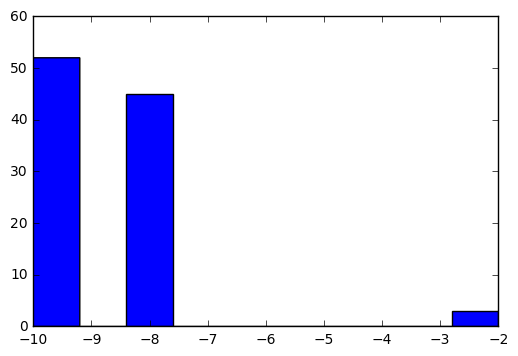

In [13]:
# Set number of games to run
num_games = 100
game_history = []
total_payoff_history = []

# Create players
player_a = Player(payoff_map, .5)
player_b = AlwaysCUntilDPlayer(payoff_map, 5)

for i in range(num_games):
    # Create and run the game
    g = Game(player_a, player_b)
    g.run()
    
    # Append to the history
    total_payoff_history.append(g.total_payoff)
    game_history.append(g)

## Plot payoff history 
_ = plt.hist(total_payoff_history)

In [14]:
# Look at a series of plays 

[(g.action_a , g.action_b) for g in game_history[:20]]

[('C', 'C'),
 ('C', 'C'),
 ('C', 'C'),
 ('D', 'C'),
 ('C', 'D'),
 ('D', 'D'),
 ('D', 'D'),
 ('D', 'D'),
 ('C', 'D'),
 ('D', 'D'),
 ('C', 'D'),
 ('D', 'D'),
 ('D', 'D'),
 ('C', 'D'),
 ('C', 'D'),
 ('C', 'D'),
 ('D', 'D'),
 ('D', 'D'),
 ('C', 'D'),
 ('C', 'D')]

### Parameter Sweep

We can now create a parameter sweep for different values of "Probability of Confessing" and "Memory Length" using nested loops. Note, this only considers a single, 100 game-length iterated PD for each parameter setting. Given your analysis goals, this might be an insufficient number to reliably characterize your model.

In [15]:
# Set number of games to run
num_games = 100
game_history = []
total_payoff_history = []


# Setup values for parameter sweep
player_a_prob_confess_values = [0.01, 0.1, 0.5, 0.9]
player_b_memory_values = [1, 5, 10, 15, 20]


# Parameter sweep

for player_a_prob_confess in player_a_prob_confess_values:
    for player_b_memory in player_b_memory_values:
        # Create players
        player_a = Player(payoff_map, player_a_prob_confess)
        player_b = AlwaysCUntilDPlayer(payoff_map, player_b_memory)

        for i in range(num_games):
            # Create and run the game
            g = Game(player_a, player_b)
            g.run()

            # Append to the history
            total_payoff_history.append((player_a_prob_confess, player_b_memory, g.total_payoff))
            game_history.append(g)

### Analysis

Given the output from the parameter sweep, we can now undetake some basic analysis of our model. Converting the day from a list format to a dataframe makes this a lot easier. 

In [16]:
import pandas
df = pandas.DataFrame(total_payoff_history, columns=["prob_confess", "memory", "payoff"])
df.head()

,prob_confess,memory,payoff
0,0.01,1,-2
1,0.01,1,-2
2,0.01,1,-2
3,0.01,1,-2
4,0.01,1,-2


In [17]:
# Show groupbys in each dimension
df.groupby("memory")["payoff"].mean()

memory
1    -5.300
5    -6.565
10   -6.550
15   -6.680
20   -7.740
Name: payoff, dtype: float64

In [18]:
# Show groupbys in each dimension
df.groupby("prob_confess")["payoff"].mean()

prob_confess
0.01   -2.748
0.10   -6.644
0.50   -8.676
0.90   -8.200
Name: payoff, dtype: float64

In [19]:
# Show groupbys in each dimension
df.groupby(["prob_confess", "memory"])["payoff"].mean()

prob_confess  memory
0.01          1        -2.16
              5        -2.48
              10       -2.00
              15       -2.00
              20       -5.10
0.10          1        -3.28
              5        -6.60
              10       -7.14
              15       -7.58
              20       -8.62
0.50          1        -7.46
              5        -8.88
              10       -8.98
              15       -8.96
              20       -9.10
0.90          1        -8.30
              5        -8.30
              10       -8.08
              15       -8.18
              20       -8.14
Name: payoff, dtype: float64

In [20]:
# Joint and unstack
df.groupby(["prob_confess", "memory"])["payoff"].mean().unstack()

memory,1,5,10,15,20
prob_confess,,,,,
0.01,-2.16,-2.48,-2.00,-2.00,-5.10
0.10,-3.28,-6.60,-7.14,-7.58,-8.62
0.50,-7.46,-8.88,-8.98,-8.96,-9.10
0.90,-8.30,-8.30,-8.08,-8.18,-8.14


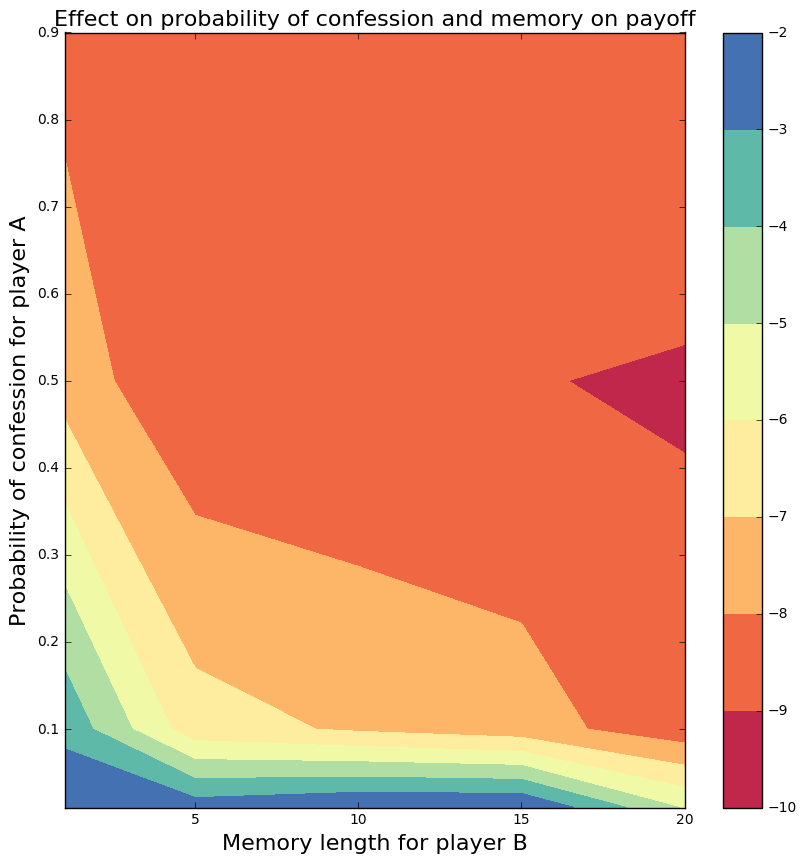

In [21]:
# Joint and unstack
payoff_surface = df.groupby(["prob_confess", "memory"])["payoff"].mean().unstack()

# Plot surface

f = plt.figure(figsize=(10, 10))
plt.contourf(payoff_surface.columns, payoff_surface.index, payoff_surface, cmap = "Spectral")
plt.colorbar()
plt.title("Effect on probability of confession and memory on payoff", fontsize=16)
plt.ylabel("Probability of confession for player A", fontsize=16)
_ = plt.xlabel("Memory length for player B", fontsize=16)

In [ ]:
# Write dataframe to file

df.to_csv("pd_sweep.csv")

Copyright (c) 2014, Michael Bommarito All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

- Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

- Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE